# Predicting Loan Payback — Kaggle Playground S5E11
**Author:** Aditya Pawar  
**Goal:** Predict probability of loan payback using XGBoost and Optuna hyperparameter tuning.

---

## Install and Import Libraries

In [1]:
!pip install optuna xgboost joblib shap --quiet

import os
import json
import joblib
import warnings
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")


---



## Paths and Filenames

Setup all file paths for saving models, Optuna database, logs, submissions, and SHAP plots.

In [2]:
DB_PATH = "/kaggle/working/xgb_optuna_resume.db"
MODEL_PATH = "/kaggle/working/best_xgb_model.pkl"
PARAM_PATH = "/kaggle/working/best_params.json"
LOG_PATH = "/kaggle/working/tuning_log.txt"
SUBMISSION_PATH = "/kaggle/working/submission.csv"
SHAP_PATH = "/kaggle/working/shap_summary.png"

---

## Load Data

Read train, test, and sample submission files. Quick shape check.


In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

X = train.drop(columns=["loan_paid_back", "id"])
y = train["loan_paid_back"].astype(int)
X_test = test.drop(columns=["id"])

----

## Exploratory Data Analysis (EDA)

Let's explore class balance, missingness, feature types, and summary statistics for `train.csv`.

In [4]:
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

print(f"\n📊 Dataset Shapes:")
print(f"   Train: {train.shape} | Test: {test.shape}")

print(f"\n📋 Memory Usage:")
print(f"   Train: {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Test: {test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n🔢 Data Types:")
print(train.dtypes.value_counts())

print(f"\n👁️ First Few Rows:")
display(train.head())

print(f"\n📈 Basic Statistics:")
display(train.describe().T)


DATASET OVERVIEW

📊 Dataset Shapes:
   Train: (593994, 13) | Test: (254569, 12)

📋 Memory Usage:
   Train: 250.50 MB
   Test: 105.41 MB

🔢 Data Types:
object     6
float64    5
int64      2
Name: count, dtype: int64

👁️ First Few Rows:


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0



📈 Basic Statistics:


,count,mean,std,min,25%,50%,75%,max
id,593994.0,296996.500000,171471.442235,0.000,148498.250,296996.500,445494.750,593993.000
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


### Target Variable Distribution

Analyze class balance and target statistics.


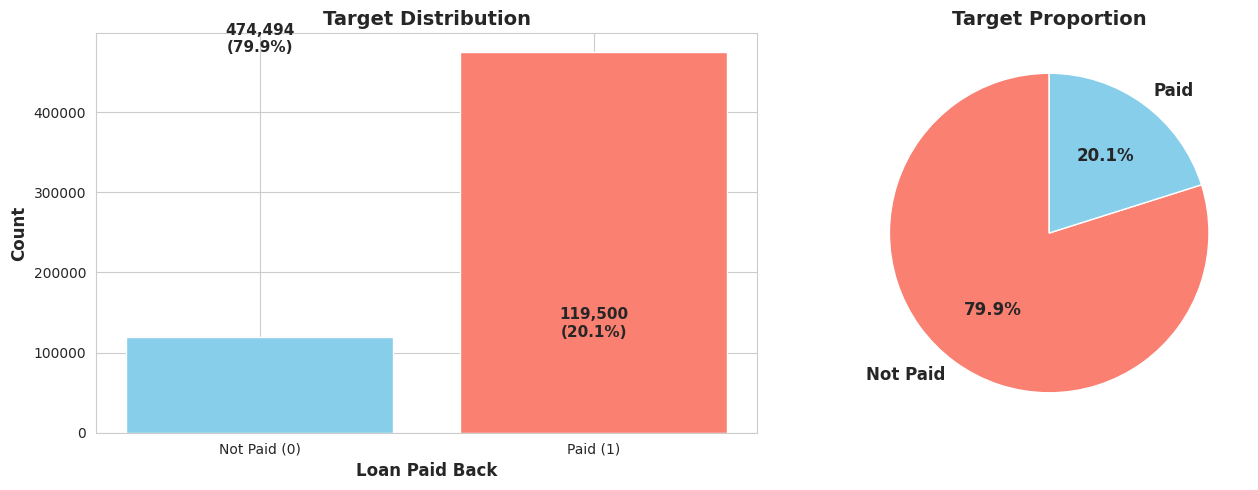


📊 Target Statistics:
   Class 0 (Not Paid): 119,500 (20.12%)
   Class 1 (Paid): 474,494 (79.88%)
   Imbalance Ratio: 0.25:1


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
target_counts = train['loan_paid_back'].value_counts()
axes[0].bar(target_counts.index, target_counts.values, color=['salmon', 'skyblue'])
axes[0].set_xlabel('Loan Paid Back', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Paid (0)', 'Paid (1)'])

# Add counts on bars
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 500, f'{v:,}\n({v/len(train)*100:.1f}%)', 
                ha='center', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['Not Paid', 'Paid'], 
           autopct='%1.1f%%', colors=['salmon', 'skyblue'], 
           startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Target Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Target Statistics:")
print(f"   Class 0 (Not Paid): {target_counts[0]:,} ({target_counts[0]/len(train)*100:.2f}%)")
print(f"   Class 1 (Paid): {target_counts[1]:,} ({target_counts[1]/len(train)*100:.2f}%)")
print(f"   Imbalance Ratio: {target_counts[0]/target_counts[1]:.2f}:1")


### Missing Values

Check for missing data across all features.


In [6]:
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)

missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)

if not missing_train.empty or not missing_test.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if not missing_train.empty:
        missing_pct_train = 100 * missing_train / len(train)
        axes[0].barh(range(len(missing_train)), missing_pct_train.values, color='coral')
        axes[0].set_yticks(range(len(missing_train)))
        axes[0].set_yticklabels(missing_train.index)
        axes[0].set_xlabel('Missing %', fontsize=12, fontweight='bold')
        axes[0].set_title('Missing Values - Train Set', fontsize=14, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'No Missing Values\nin Train Set', 
                    ha='center', va='center', fontsize=16, fontweight='bold')
        axes[0].axis('off')
    
    if not missing_test.empty:
        missing_pct_test = 100 * missing_test / len(test)
        axes[1].barh(range(len(missing_test)), missing_pct_test.values, color='lightblue')
        axes[1].set_yticks(range(len(missing_test)))
        axes[1].set_yticklabels(missing_test.index)
        axes[1].set_xlabel('Missing %', fontsize=12, fontweight='bold')
        axes[1].set_title('Missing Values - Test Set', fontsize=14, fontweight='bold')
        axes[1].grid(axis='x', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No Missing Values\nin Test Set', 
                    ha='center', va='center', fontsize=16, fontweight='bold')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values in train or test sets!")


✅ No missing values in train or test sets!


### Numerical Features Analysis

Distribution and statistics of numerical columns.


📊 Found 5 numerical features
   ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']



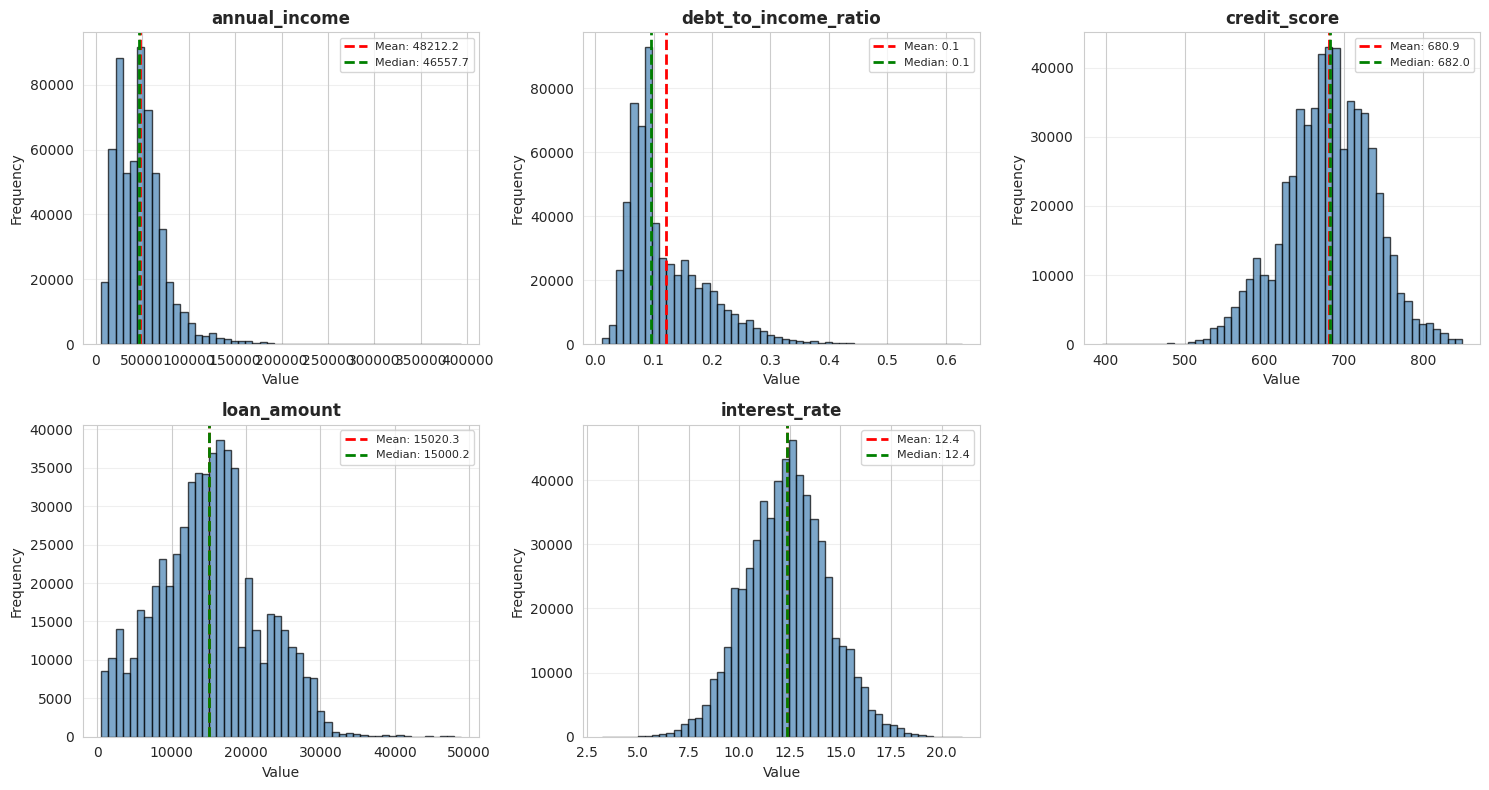

In [7]:
X_temp = train.drop(columns=['loan_paid_back', 'id'])
numeric_cols = X_temp.select_dtypes(include=[np.number]).columns

print(f"📊 Found {len(numeric_cols)} numerical features")
print(f"   {list(numeric_cols)}\n")

# Plot distributions
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if len(numeric_cols) == 1 else axes

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(train[col].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Value', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add statistics
    mean_val = train[col].mean()
    median_val = train[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    axes[idx].legend(fontsize=8)

# Hide extra subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


### Feature Distributions by Target Class

Compare numerical features across paid vs not paid loans.


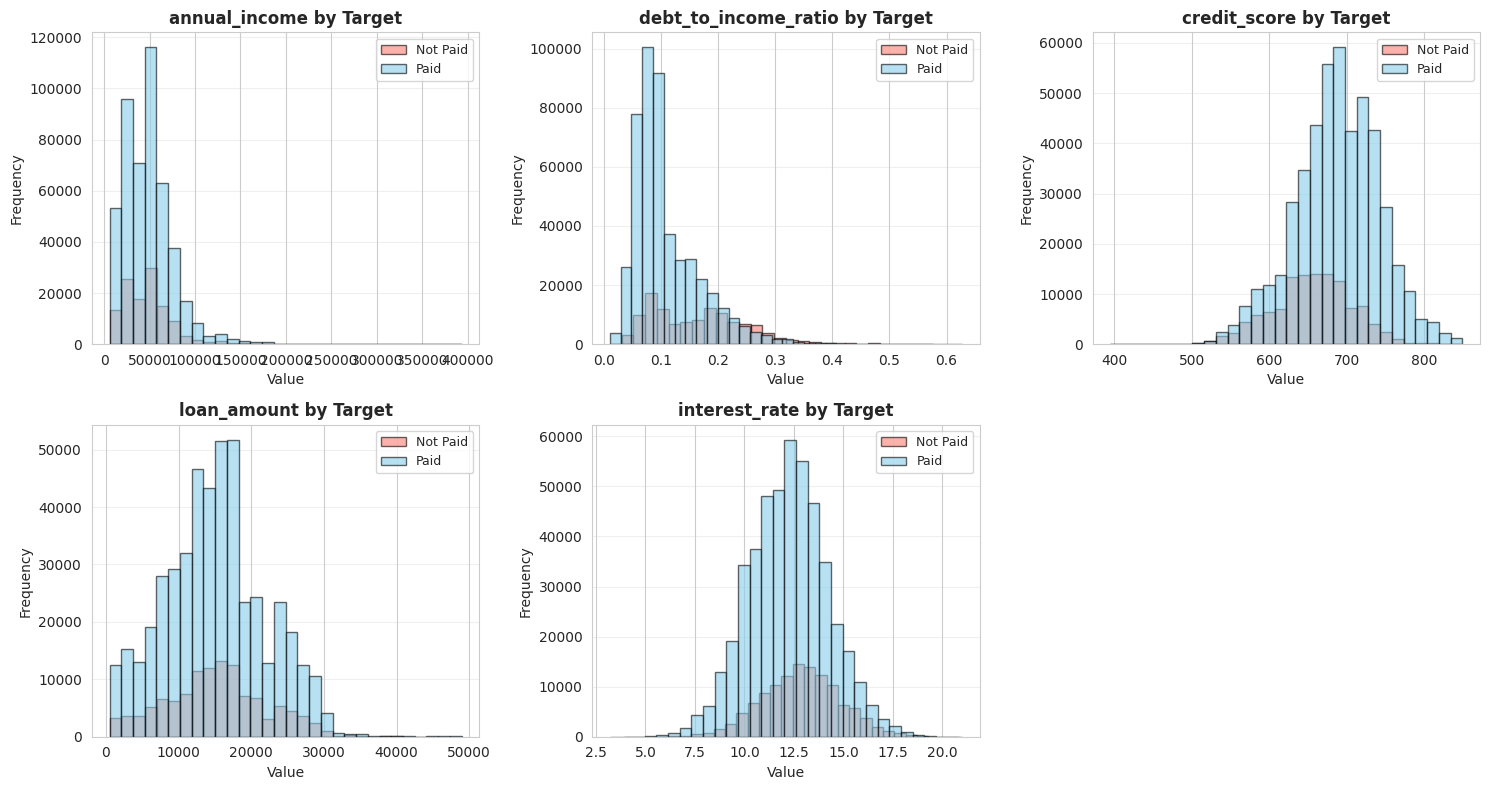

In [8]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if len(numeric_cols) == 1 else axes

for idx, col in enumerate(numeric_cols):
    train[train['loan_paid_back'] == 0][col].hist(
        bins=30, alpha=0.6, label='Not Paid', color='salmon', ax=axes[idx], edgecolor='black'
    )
    train[train['loan_paid_back'] == 1][col].hist(
        bins=30, alpha=0.6, label='Paid', color='skyblue', ax=axes[idx], edgecolor='black'
    )
    axes[idx].set_title(f'{col} by Target', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Value', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


### Categorical Features Analysis

Distribution of categorical variables and their relationship with target.


📊 Found 6 categorical features
   ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


Feature: gender
Unique values: 3

Top 10 categories:
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64


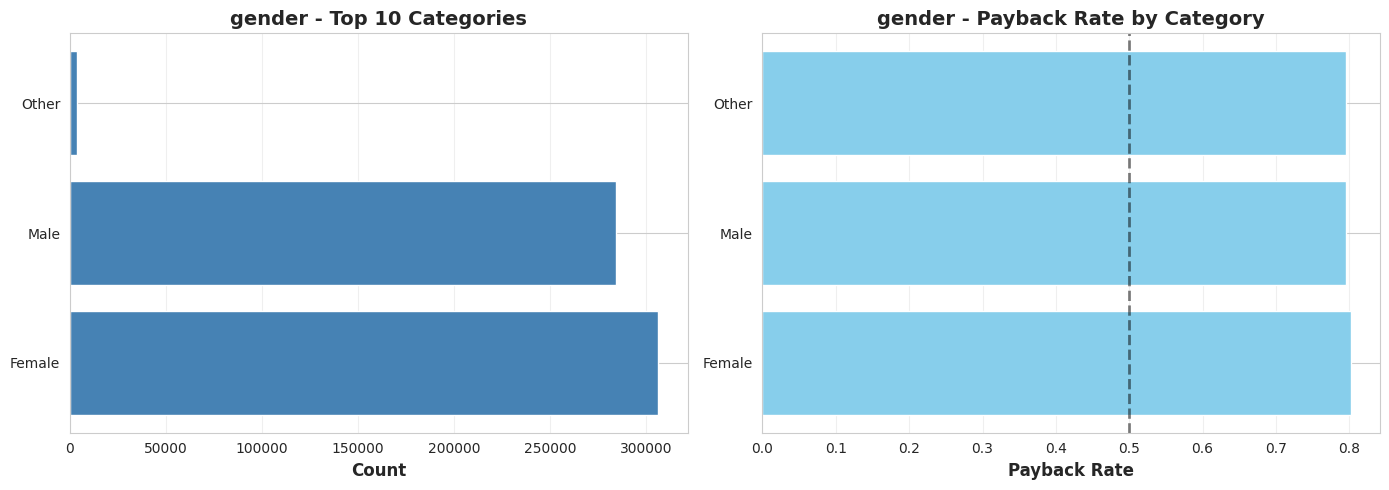


Feature: marital_status
Unique values: 4

Top 10 categories:
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64


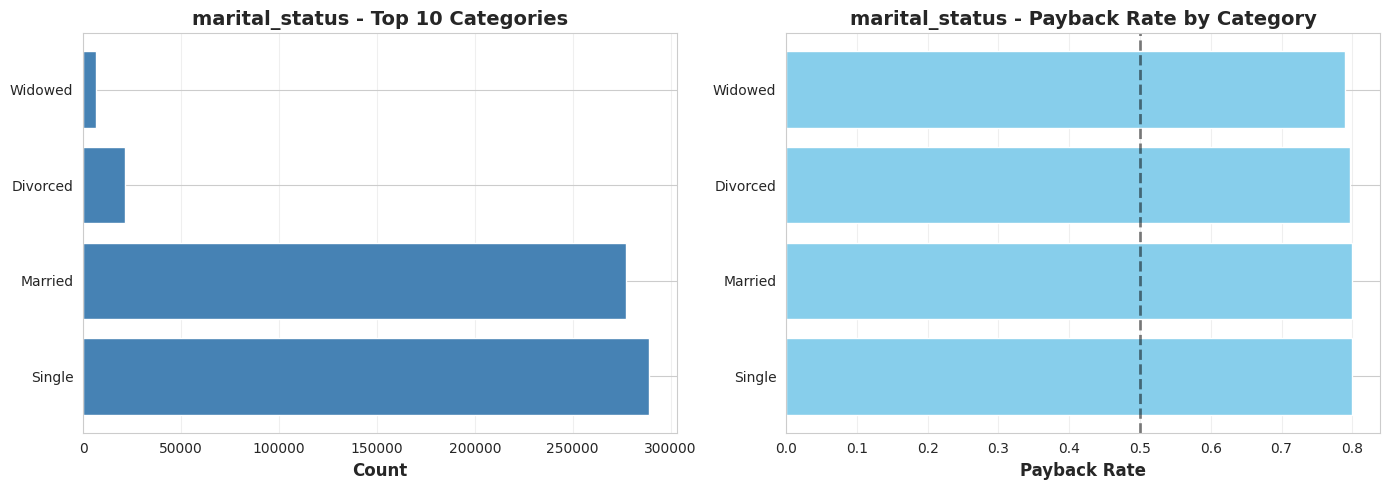


Feature: education_level
Unique values: 5

Top 10 categories:
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64


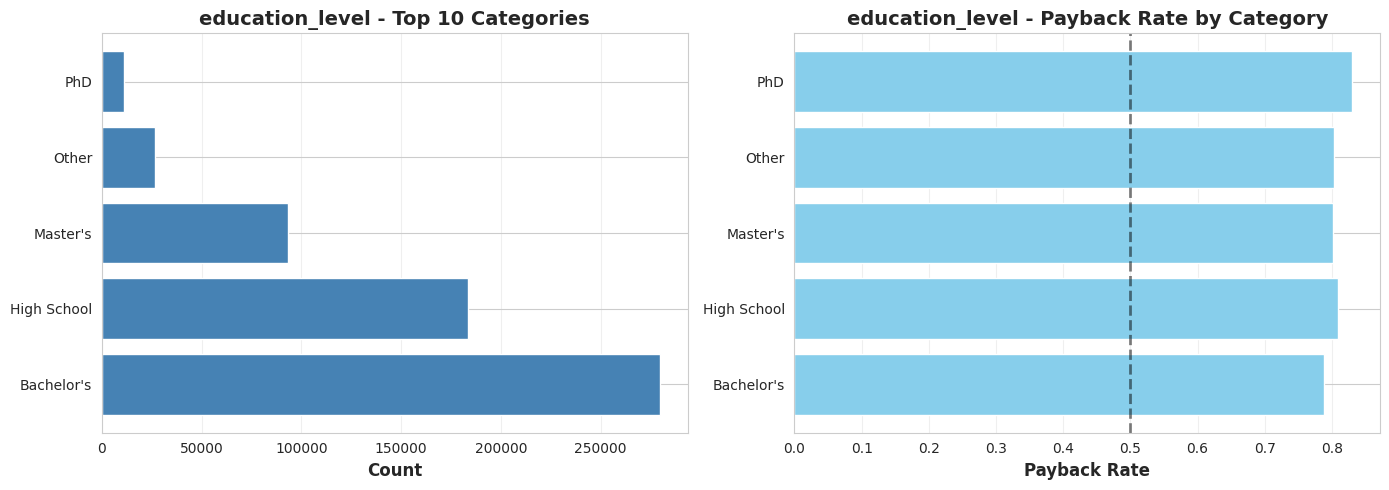


Feature: employment_status
Unique values: 5

Top 10 categories:
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64


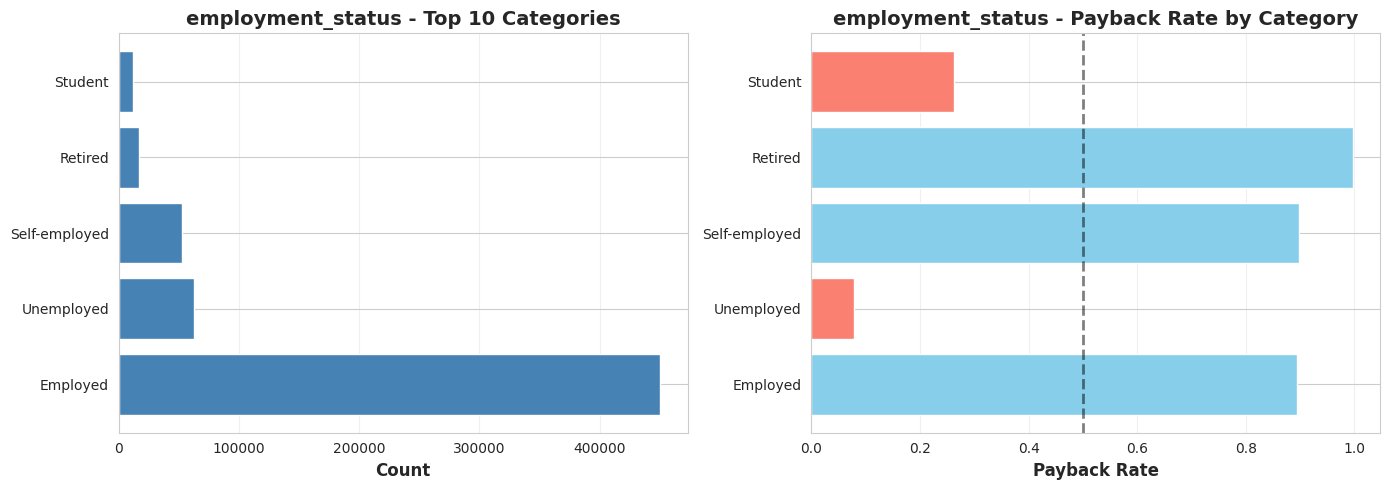


Feature: loan_purpose
Unique values: 8

Top 10 categories:
loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business               35303
Medical                22806
Vacation                8449
Name: count, dtype: int64


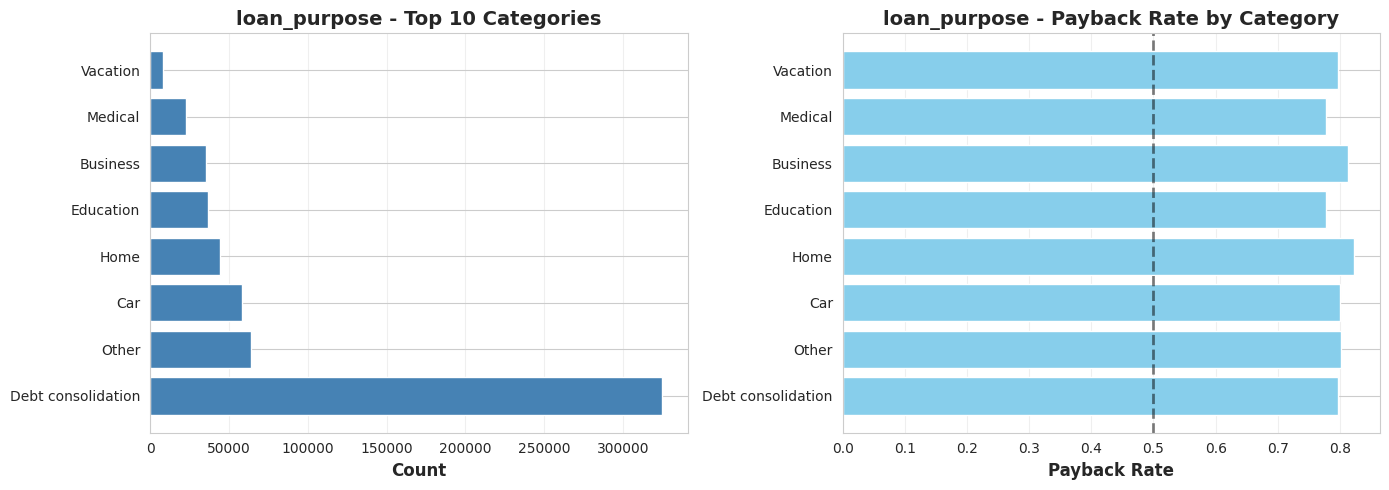


Feature: grade_subgrade
Unique values: 30

Top 10 categories:
grade_subgrade
C3    58695
C4    55957
C2    54443
C1    53363
C5    53317
D1    37029
D3    36694
D4    35097
D2    34432
D5    32101
Name: count, dtype: int64


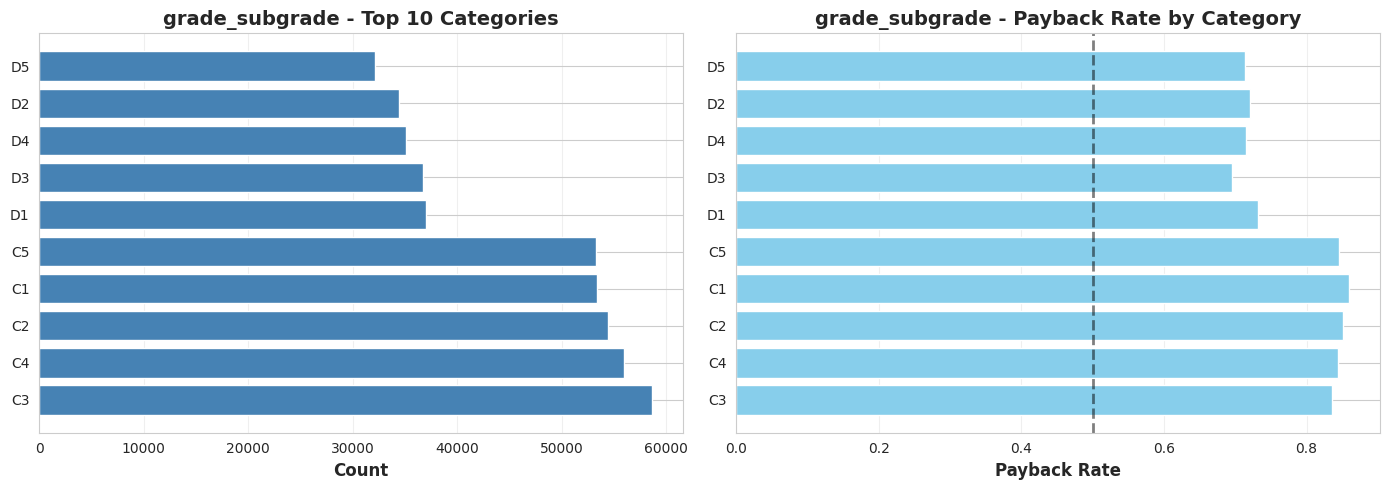

In [9]:
cat_cols = X_temp.select_dtypes(exclude=[np.number]).columns

print(f"📊 Found {len(cat_cols)} categorical features")
print(f"   {list(cat_cols)}\n")

if len(cat_cols) > 0:
    for col in cat_cols:
        print(f"\n{'='*80}")
        print(f"Feature: {col}")
        print(f"{'='*80}")
        
        value_counts = train[col].value_counts()
        print(f"Unique values: {train[col].nunique()}")
        print(f"\nTop 10 categories:")
        print(value_counts.head(10))
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Overall distribution
        top_cats = value_counts.head(10)
        axes[0].barh(range(len(top_cats)), top_cats.values, color='steelblue')
        axes[0].set_yticks(range(len(top_cats)))
        axes[0].set_yticklabels(top_cats.index)
        axes[0].set_xlabel('Count', fontsize=12, fontweight='bold')
        axes[0].set_title(f'{col} - Top 10 Categories', fontsize=14, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)
        
        # By target
        top_cat_list = top_cats.index.tolist()
        payback_rates = []
        for cat in top_cat_list:
            rate = train[train[col] == cat]['loan_paid_back'].mean()
            payback_rates.append(rate)
        
        colors = ['salmon' if r < 0.5 else 'skyblue' for r in payback_rates]
        axes[1].barh(range(len(top_cat_list)), payback_rates, color=colors)
        axes[1].set_yticks(range(len(top_cat_list)))
        axes[1].set_yticklabels(top_cat_list)
        axes[1].set_xlabel('Payback Rate', fontsize=12, fontweight='bold')
        axes[1].set_title(f'{col} - Payback Rate by Category', fontsize=14, fontweight='bold')
        axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
        axes[1].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("No categorical features found.")


### Correlation Matrix

Analyze relationships between numerical features.


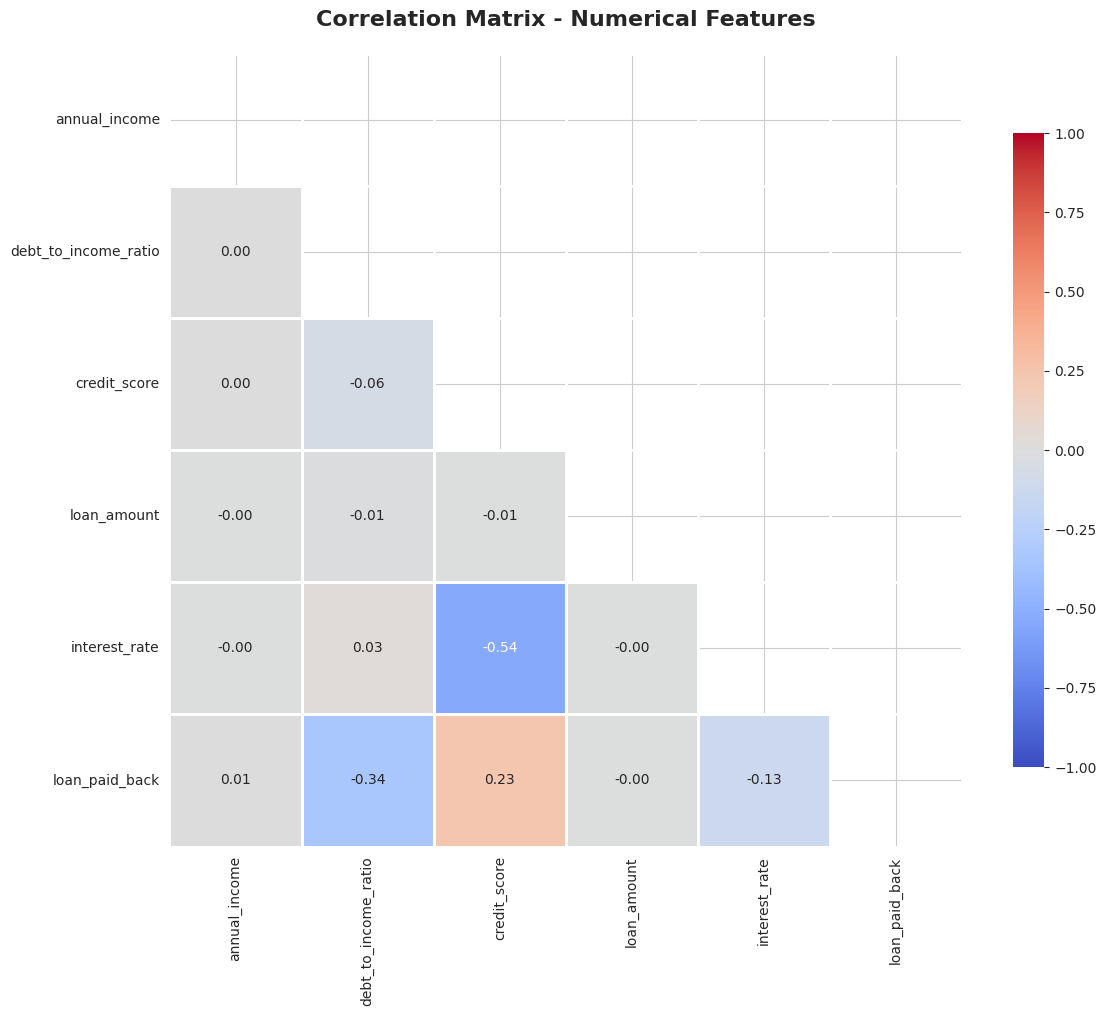


🎯 Correlation with Target (loan_paid_back):
credit_score            0.234560
annual_income           0.006326
loan_amount            -0.003762
interest_rate          -0.131184
debt_to_income_ratio   -0.335680


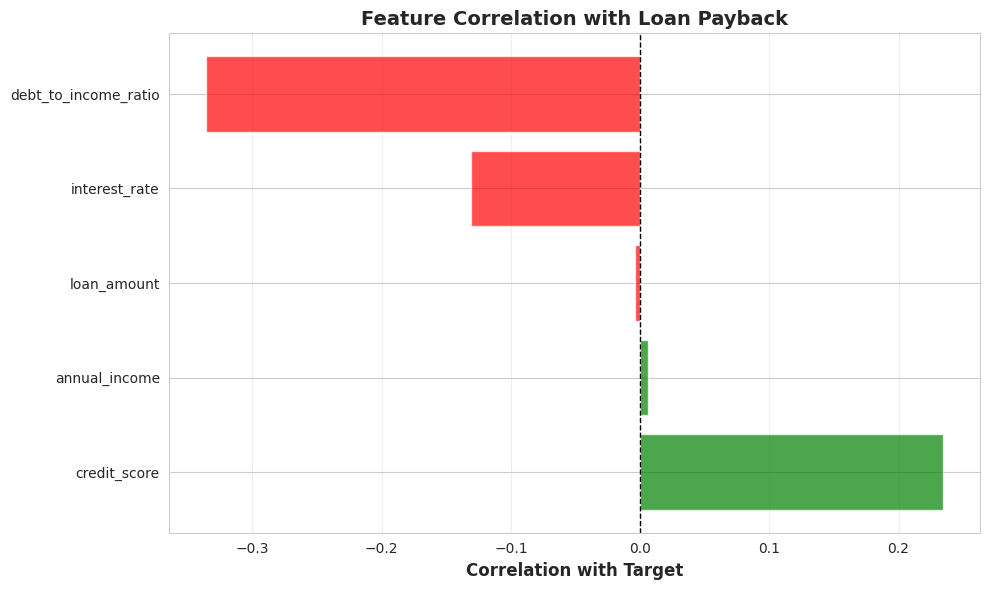


🔗 Highly Correlated Feature Pairs (|corr| > 0.7):
   None found (multicollinearity is low).


In [10]:
if len(numeric_cols) > 0:
    # Include target variable in correlation analysis
    numeric_cols_with_target = list(numeric_cols) + ['loan_paid_back']
    corr_matrix = train[numeric_cols_with_target].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, square=True, 
                linewidths=1, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1)
    plt.title('Correlation Matrix - Numerical Features', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Show correlation with target
    print("\n🎯 Correlation with Target (loan_paid_back):")
    target_corr = corr_matrix['loan_paid_back'].drop('loan_paid_back').sort_values(ascending=False)
    print(target_corr.to_string())
    
    # Plot target correlations
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in target_corr.values]
    plt.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
    plt.yticks(range(len(target_corr)), target_corr.index)
    plt.xlabel('Correlation with Target', fontsize=12, fontweight='bold')
    plt.title('Feature Correlation with Loan Payback', fontsize=14, fontweight='bold')
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated feature pairs (excluding target)
    print("\n🔗 Highly Correlated Feature Pairs (|corr| > 0.7):")
    high_corr = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    
    if high_corr:
        for feat1, feat2, corr_val in high_corr:
            print(f"   {feat1} ↔ {feat2}: {corr_val:.3f}")
    else:
        print("   None found (multicollinearity is low).")
else:
    print("⚠️ No numerical features found for correlation analysis.")


### Quick Feature Importance

Train a simple model to get baseline feature importance.


🌲 Training Random Forest for feature importance...


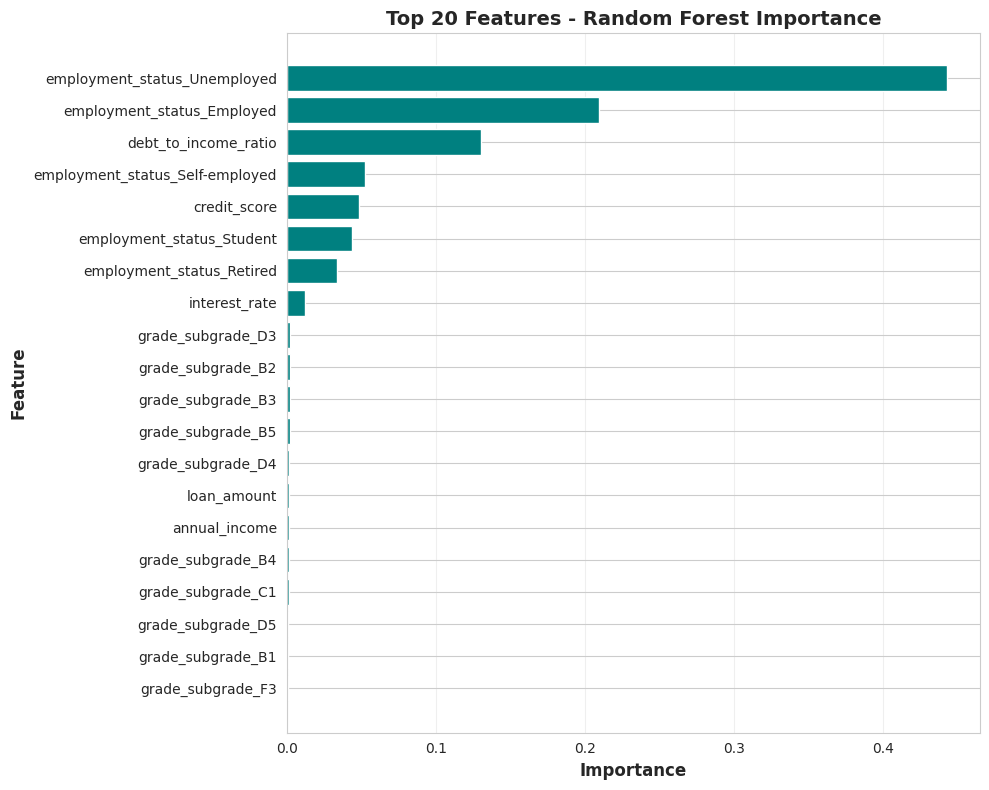


📋 Top 10 Most Important Features:


,feature,importance
21,employment_status_Unemployed,0.443085
17,employment_status_Employed,0.209745
1,debt_to_income_ratio,0.130274
19,employment_status_Self-employed,0.052490
2,credit_score,0.048574
20,employment_status_Student,0.043898
18,employment_status_Retired,0.033392
4,interest_rate,0.012120
47,grade_subgrade_D3,0.002246
36,grade_subgrade_B2,0.001950



✅ Quick RF Model Performance:
   Training Accuracy: 0.9002


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data
X_sample = train.drop(columns=['loan_paid_back', 'id']).fillna(-999)
y_sample = train['loan_paid_back']

# One-hot encode
X_sample_encoded = pd.get_dummies(X_sample)

# Train quick RF
print("🌲 Training Random Forest for feature importance...")
rf_quick = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_quick.fit(X_sample_encoded, y_sample)

# Get importance
feature_importance = pd.DataFrame({
    'feature': X_sample_encoded.columns,
    'importance': rf_quick.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'].values, color='teal')
plt.yticks(range(len(feature_importance)), feature_importance['feature'].values)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 20 Features - Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📋 Top 10 Most Important Features:")
display(feature_importance.head(10))

print(f"\n✅ Quick RF Model Performance:")
print(f"   Training Accuracy: {rf_quick.score(X_sample_encoded, y_sample):.4f}")

## Feature Engineering for Maximum AUC Boost

Create domain-specific financial features, interactions, and transformations proven to improve loan prediction models.


## Preprocessing

Drop ID and target columns from features, handle missing values, perform one-hot encoding, and align test set columns.

In [12]:
# Separate numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

# Fill missing values for training and test
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())
    X_test[col] = X_test[col].fillna(X[col].median())
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])
    X_test[col] = X_test[col].fillna(X[col].mode()[0])

# One-hot encoding of categorical columns, align test columns to train
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

In [13]:
# ================================
# 7. GPU-Optimized Data Preparation
# ================================
print("\n🚀 Converting to GPU-optimized format...")
X_gpu = X.astype('float32').values
X_test_gpu = X_test.astype('float32').values
y_np = y.astype('int32').values

print(f"✅ X_gpu: {X_gpu.shape}, dtype: {X_gpu.dtype}")
print(f"   Memory: {X_gpu.nbytes / 1024**2:.2f} MB")

# ================================
# 8. GPU Check
# ================================
import subprocess
try:
    gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'])
    print("\n✅ GPU Available:")
    print(gpu_info.decode('utf-8'))
except:
    print("\n⚠️ No GPU detected - running on CPU")

# ================================
# 9. Optuna Objective Function (GPU-Optimized)
# ================================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 800, 2000),
        "max_depth": trial.suggest_int("max_depth", 4, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 12),
        "gamma": trial.suggest_float("gamma", 0.0, 2.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.5),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 4.0),
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "max_bin": 512,
        "grow_policy": "depthwise",
        "random_state": 42,
    }
    
    kf = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
    aucs = []

    for train_idx, valid_idx in kf.split(X_gpu):
        dtrain = xgb.DMatrix(X_gpu[train_idx], label=y_np[train_idx])
        dvalid = xgb.DMatrix(X_gpu[valid_idx], label=y_np[valid_idx])
        
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=params['n_estimators'],
            evals=[(dvalid, 'eval')],
            early_stopping_rounds=20,
            verbose_eval=False
        )

        aucs.append(roc_auc_score(y_np[valid_idx], bst.predict(dvalid)))

    return 1 - np.mean(aucs)


🚀 Converting to GPU-optimized format...
✅ X_gpu: (593994, 60), dtype: float32
   Memory: 135.95 MB

✅ GPU Available:
Tesla P100-PCIE-16GB, 16384 MiB



## Create or Resume Optuna Study

Resume previous search or create new study, with pruning for efficiency.

In [14]:
if os.path.exists(DB_PATH):
    print("🔄 Resuming tuning from previous database...\n")
    study = optuna.load_study(study_name="xgb_opt", storage=f"sqlite:///{DB_PATH}")
    prev_trials = len(study.trials)
    print(f"📊 Previous trials count: {prev_trials}")
else:
    print("🆕 Creating a new study...\n")
    study = optuna.create_study(
        study_name="xgb_opt", direction="minimize",
        pruner=optuna.pruners.MedianPruner(),
        storage=f"sqlite:///{DB_PATH}"
    )
    prev_trials = 0

🆕 Creating a new study...



[I 2025-11-17 18:37:27,433] A new study created in RDB with name: xgb_opt


## Run Hyperparameter Search

Run Optuna optimization for 30 trials (edit as needed for more trials for accuracy).


In [15]:
study.optimize(objective, n_trials=30, show_progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-17 18:37:35,367] Trial 0 finished with value: 0.08442208330413725 and parameters: {'n_estimators': 1726, 'max_depth': 4, 'learning_rate': 0.047683168855292016, 'subsample': 0.9251067945785848, 'colsample_bytree': 0.8723436601857353, 'min_child_weight': 11, 'gamma': 1.3354959562903481, 'reg_alpha': 0.6352905378269208, 'reg_lambda': 2.4037653144161086, 'scale_pos_weight': 1.6354923015966518}. Best is trial 0 with value: 0.08442208330413725.
[I 2025-11-17 18:37:39,680] Trial 1 finished with value: 0.08422366651954372 and parameters: {'n_estimators': 960, 'max_depth': 6, 'learning_rate': 0.10765855710193237, 'subsample': 0.8888118106160663, 'colsample_bytree': 0.8203920478904076, 'min_child_weight': 11, 'gamma': 2.149051234333685, 'reg_alpha': 1.3540360629635413, 'reg_lambda': 1.3021241866424882, 'scale_pos_weight': 2.2697047060401614}. Best is trial 1 with value: 0.08422366651954372.
[I 2025-11-17 18:37:46,800] Trial 2 finished with value: 0.08317096265199808 and parameters: {'

## Train Final Model

Train XGBoost using the best parameters found and save the artifacts.

In [16]:
import json
import joblib

best_params = study.best_params
best_auc = 1 - study.best_value

# ANSI color codes for emphasis (e.g., bright green)
GREEN = "\033[92m"
BOLD = "\033[1m"
RESET = "\033[0m"

print(f"\n{BOLD}{GREEN}🏆 Best AUC: {best_auc:.6f}{RESET}")
print(f"{BOLD}Best Parameters:{RESET}")
print(json.dumps(best_params, indent=2))

best_model = xgb.XGBClassifier(
    **best_params,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    n_jobs=-1,
    use_label_encoder=False
)
best_model.fit(X, y)

joblib.dump(best_model, MODEL_PATH)
with open(PARAM_PATH, "w") as f:
    json.dump(best_params, f, indent=2)

print(f"\n{GREEN}✅ Model saved at: {MODEL_PATH}{RESET}")
print(f"✅ Best parameters saved at: {PARAM_PATH}")
print(f"✅ Tuning log saved at: {LOG_PATH}")


🏆 Best AUC: 0.921669
Best Parameters:
{
  "n_estimators": 1964,
  "max_depth": 8,
  "learning_rate": 0.023314589680321803,
  "subsample": 0.7774255133211497,
  "colsample_bytree": 0.9392621430697066,
  "min_child_weight": 3,
  "gamma": 0.16235383057033398,
  "reg_alpha": 1.666528878438,
  "reg_lambda": 0.6133451364870748,
  "scale_pos_weight": 1.4054971367631224
}

✅ Model saved at: /kaggle/working/best_xgb_model.pkl
✅ Best parameters saved at: /kaggle/working/best_params.json
✅ Tuning log saved at: /kaggle/working/tuning_log.txt


## Create Submission

Generate and save predictions for test set for Kaggle submission.


In [17]:
preds = best_model.predict_proba(X_test)[:,1]
submission = pd.DataFrame({"id": test["id"], "loan_paid_back": preds.clip(0, 1)})
submission.to_csv(SUBMISSION_PATH, index=False)
print(f"\n✅ Submission ready at: {SUBMISSION_PATH}")


✅ Submission ready at: /kaggle/working/submission.csv
